# Running Your First Models

In this example, we'll run three UCLCHEM models using the cloud model and the python wrapper. To do so, you'll need to create the python module by running

```make python```

from the ```src/``` folder. This will produce ```uclchem.so``` which is imported by this notebook. You should also ensure the ```PHYSICS``` variable in the Makefile is set to cloud.f90.

There are two major functions in the uclchem library, we'll use ```uclchem.wrap.run_model_to_file()``` for this example. It takes a dictionary of inputs which can include any of the parameters in ```src/defaultparameters.f90```. It also takes a string containing a space separated list of species names to use for the (optional) columnated output.

In [1]:
from sys import path
path.insert(0,"../")#make sure uclchem.so is in our path
import uclchem
import pandas as pd
import matplotlib.pyplot as plt

# Phase 1

It's typical when running UCLCHEM to run the model in two phases. If, for example, one wishes to model a hot core, the gas should be well processed by the time the protostar "turns on". This could be achieved by initializing the abundances to some known values for a prestellar core but instead we do the following:

- Run a model starting from some very diffuse, atomic gas
- Allow it to collapse in freefall to the density of the object we wish to model
- Store the abundances as the initial abundances for the hot core model

UCLCHEM is set up to do this through the ```phase``` parameter. All physics modules will model a homogenous cloud that can collapse under freefall when ```phase=1``` and then they do their specific physical model when ```phase=2```

In [3]:
#set a parameter dictionary for phase 1 collapse model

outSpecies="SO CO"
param_dict = {"phase": 1, "switch": 1, "collapse": 1, "readAbunds": 0, "writeStep": 1,
               "outSpecies": len(outSpecies.split()), "initialDens": 1e2, "initialTemp":10.0,
               "finalDens":1e5, "finalTime":5.0e6,
               "outputFile":"test-output/phase1-full.dat",
               "abundFile":"test-output/startcollapse.dat"}
uclchem.wrap.run_model_to_file(dictionary=param_dict, outspeciesin=outSpecies)


We can look at the output for that model by using pandas to read the file (skipping 2 rows to miss the header) and matplotlib to view abundances.

In [4]:
phase1_df=pd.read_csv("test-output/phase1-full.dat",skiprows=2)
phase1_df.columns=phase1_df.columns.str.strip()

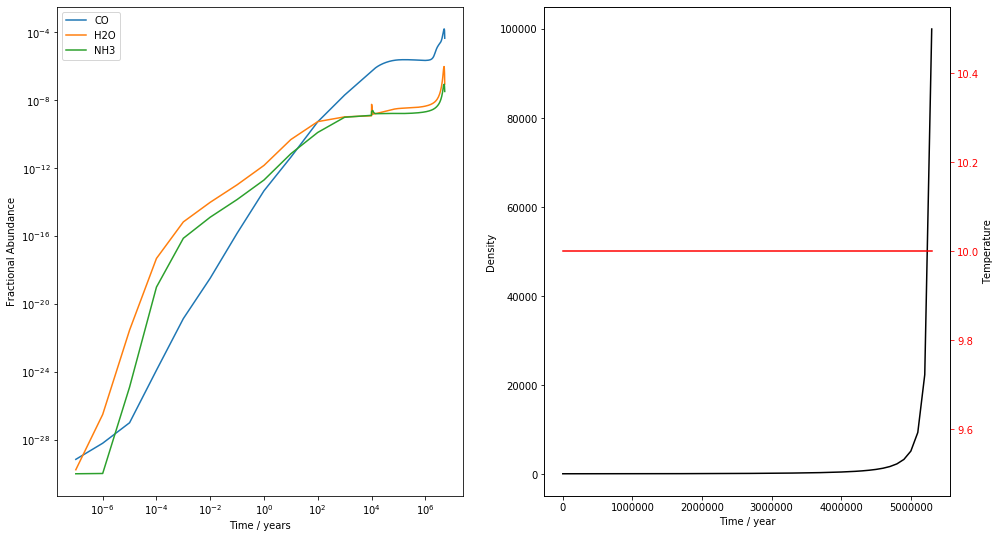

In [5]:
fig,[ax,ax2]=plt.subplots(1,2,figsize=(16,9))
for species in ["CO","H2O","NH3"]:
    ax.plot(phase1_df["Time"],phase1_df[species],label=species)
ax.legend()
settings=ax.set(yscale="log",xscale="log",xlabel="Time / years", ylabel="Fractional Abundance")

ax2.plot(phase1_df["Time"],phase1_df["Density"],color="black")
ax3=ax2.twinx()
ax3.plot(phase1_df["Time"],phase1_df["gasTemp"],color="red")
ax2.set(xlabel="Time / year",ylabel="Density")
ax3.set(ylabel="Temperature",facecolor="red")
ax3.tick_params(axis='y', colors='red')

# Phase 2

Note the ```abundFile``` and ```readAbunds``` parameters in our phase 1 model. If ```readAbunds``` is set to 0 then the abundances at the end of the model are written to ```abundFile```. If, instead, ```readAbunds``` is set to 1, the initial abundances are read from that file. Thus by switching ```readAbunds``` over, we can run phase 2 starting from the final abundances of the previous model.

In [ ]:
#read old abundances and do hot core behaviour
param_dict["readAbunds"]=1
param_dict["phase"]=2

#change other bits of input to set up phase 2
param_dict["initialDens"]=1e5
param_dict["tempindx"]=3 #selects mass of protostar (see cloud.f90)
param_dict["finalTime"]=1e6
param_dict["switch"]=0
param_dict["abundFile"]="test-output/startcollapse.dat"
param_dict["outputFile"]="test-output/phase2-full.dat"


uclchem.wrap.run_model_to_file(dictionary=param_dict, outspeciesin=outSpecies)

In [4]:
phase2_df=pd.read_csv("test-output/phase2-full.dat",skiprows=2)
phase2_df.columns=phase2_df.columns.str.strip()

In [5]:
phase2_df

,Time,Density,gasTemp,av,point,H,#H,H+,@H,H2,...,HS2,HS2+,HSO2+,H2S2+,H2S2,#H2S2,@H2S2,BULK,SURFACE,E-
0,1.000000e-07,100100.0,10.00,11.653,1,0.000002,3.158670e-27,5.943070e-11,3.09490E-26,4.99765E-01,...,2.651390e-12,1.691820e-14,3.269320e-15,3.114220e-16,5.395060e-14,1.87690E-12,1.837270e-11,4.77339E-04,0.000049,2.325240e-07
1,1.000000e-06,100100.0,10.00,11.653,1,0.000002,3.158670e-27,5.943070e-11,3.09490E-26,4.99765E-01,...,2.651390e-12,1.691820e-14,3.269320e-15,3.114220e-16,5.395060e-14,1.87690E-12,1.837270e-11,4.77339E-04,0.000049,2.325240e-07
2,1.000000e-05,100100.0,10.00,11.653,1,0.000002,3.158670e-27,5.943070e-11,3.09490E-26,4.99765E-01,...,2.651390e-12,1.691820e-14,3.269320e-15,3.114220e-16,5.395060e-14,1.87690E-12,1.837270e-11,4.77339E-04,0.000049,2.325240e-07
3,1.000000e-04,100100.0,10.00,11.653,1,0.000002,3.158670e-27,5.943070e-11,3.09490E-26,4.99765E-01,...,2.651390e-12,1.691820e-14,3.269320e-15,3.114220e-16,5.395060e-14,1.87690E-12,1.837270e-11,4.77339E-04,0.000049,2.325240e-07
4,1.000000e-03,100100.0,10.00,11.653,1,0.000002,3.158660e-27,5.943070e-11,3.09490E-26,4.99765E-01,...,2.651390e-12,1.691820e-14,3.269320e-15,3.114220e-16,5.395060e-14,1.87689E-12,1.837270e-11,4.77339E-04,0.000049,2.325240e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13550,7.610000e+04,100100.0,108.32,11.653,1,0.000000,0.000000e+00,0.000000e+00,0,0,...,1.890940e-08,1.851420e-13,0.000000e+00,1.834510e-13,2.336150e-08,0,-2.802190e-55,0,0.000000,0.000000e+00
13551,7.610000e+04,100100.0,108.32,11.653,1,0.000000,0.000000e+00,0.000000e+00,0,0,...,1.890940e-08,1.851420e-13,0.000000e+00,1.834510e-13,2.336150e-08,0,-2.802190e-55,0,0.000000,0.000000e+00
13552,7.610000e+04,100100.0,108.32,11.653,1,0.000000,0.000000e+00,0.000000e+00,0,0,...,1.890940e-08,1.851420e-13,0.000000e+00,1.834510e-13,2.336150e-08,0,-2.802190e-55,0,0.000000,0.000000e+00
13553,7.610000e+04,100100.0,108.32,11.653,1,0.000000,0.000000e+00,0.000000e+00,0,0,...,1.890940e-08,1.851420e-13,0.000000e+00,1.834510e-13,2.336150e-08,0,-2.802190e-55,0,0.000000,0.000000e+00


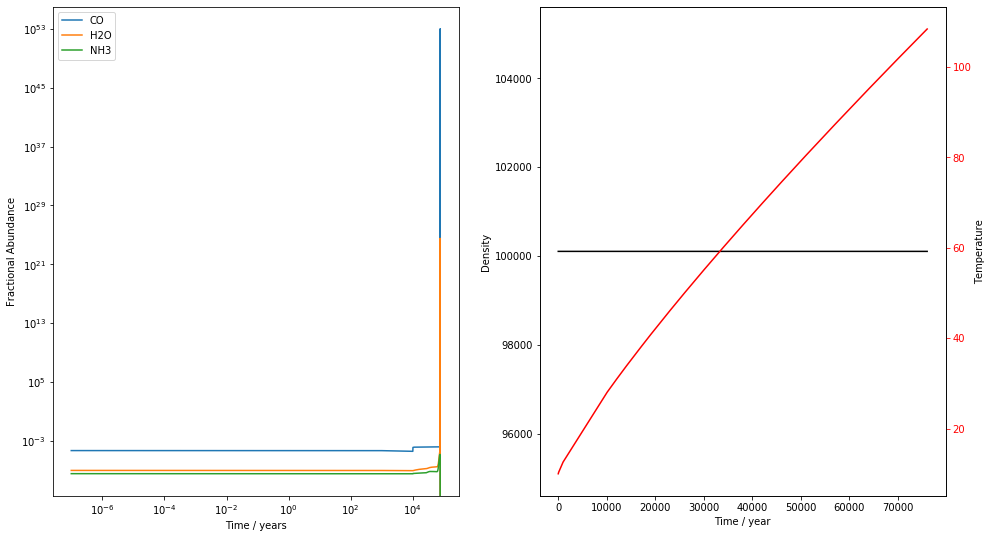

In [6]:
fig,[ax,ax2]=plt.subplots(1,2,figsize=(16,9))
for species in ["CO","H2O","NH3"]:
    ax.plot(phase2_df["Time"],phase2_df[species],label=species)
ax.legend()
settings=ax.set(yscale="log",xscale="log",xlabel="Time / years", ylabel="Fractional Abundance")

ax2.plot(phase2_df["Time"],phase2_df["Density"],color="black")
ax3=ax2.twinx()
ax3.plot(phase2_df["Time"],phase2_df["gasTemp"],color="red")
ax2.set(xlabel="Time / year",ylabel="Density")
ax3.set(ylabel="Temperature",facecolor="red")
ax3.tick_params(axis='y', colors='red')